# Audio Processing Basics

This tutorial introduces to basics of processing digital audio in Python

## General Requirements

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
import glob

import progressbar

import IPython

## Requirements for Digital Audio Processing

### Audio Processing Library

Tell Tensorflow which GPU to use (if you have more than one)

In [2]:
import librosa

## Data

**Music Speech Data Set**

by *George Tzanetakis*. Collected for the purposes of music/speech discrimination. Consists of 128 tracks, each 30 seconds long. Each class (music/speech) has 64 examples in 22050Hz Mono 16-bit WAV audio format. 

In [3]:
DATASET_PATH = "D:/Research/Data/MIR/gtzan_music_speech"

**Prepare Metadata**

In [4]:
MUSIC_DIR  = "%s/music" % DATASET_PATH
SPEECH_DIR = "%s/speech" % DATASET_PATH

In [5]:
music_files  = glob.glob(os.path.join(MUSIC_DIR, "*.wav"))
music_files  = [f.replace("\\", "/") for f in music_files]

speech_files = glob.glob(os.path.join(SPEECH_DIR, "*.wav"))
speech_files = [f.replace("\\", "/") for f in speech_files]

metadata_music  = pd.DataFrame({"filename": music_files,  "label": ["music" for _ in range(len(music_files))]})
metadata_speech = pd.DataFrame({"filename": speech_files, "label": ["music" for _ in range(len(speech_files))]})

metadata = pd.concat([metadata_music, metadata_speech], axis=0, ignore_index=True)
metadata.head()

,filename,label
0,D:/Research/Data/MIR/gtzan_music_speech/music/...,music
1,D:/Research/Data/MIR/gtzan_music_speech/music/...,music
2,D:/Research/Data/MIR/gtzan_music_speech/music/...,music
3,D:/Research/Data/MIR/gtzan_music_speech/music/...,music
4,D:/Research/Data/MIR/gtzan_music_speech/music/...,music


# Processing Audio

**Loading an Audio File**

In [6]:
y, sample_rate = librosa.load(metadata.iloc[0].filename, mono=True, sr=None)

Visualize Audio File

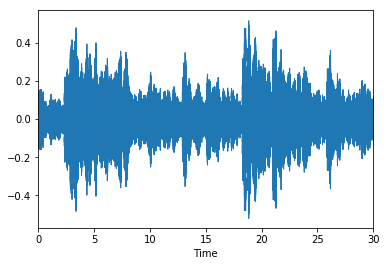

In [7]:
from librosa import display
librosa.display.waveplot(y, sr=sample_rate);

In [8]:
IPython.display.Audio(metadata.iloc[0].filename)

**Fourier Transform**

In [9]:
spectrogram = librosa.stft(y,
                           n_fft      = 1024,
                           hop_length = 512)

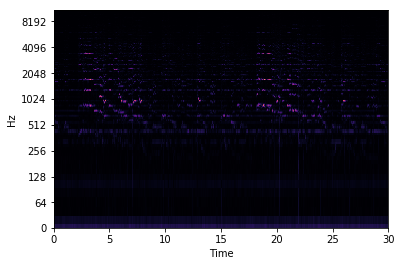

In [10]:
librosa.display.specshow(np.abs(spectrogram), y_axis='log', x_axis='time', sr=sample_rate);

Log-amplitude transformation / Decibel Transformation

In [11]:
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

Show Spectrogram

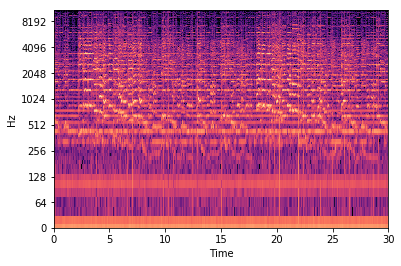

In [12]:
librosa.display.specshow(spectrogram_db, sr=sample_rate, y_axis='log', x_axis='time');

**Mel-Transform**

In [13]:
power_spectrogram = np.abs(spectrogram)**2

melspec           = librosa.feature.melspectrogram(S      = power_spectrogram,
                                                   n_mels = 80,
                                                   fmax   = 8000)

In [14]:
melspec_db = librosa.power_to_db(melspec, ref = np.max)

In [15]:
melspec_db.shape

(80, 1292)

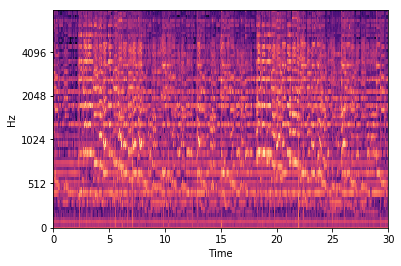

In [16]:
librosa.display.specshow(melspec_db, y_axis='mel', fmax=8000, x_axis='time');

# Extract Features for Example 1

## Define Feature extraction Function

In [17]:
def load_mel_spec(filename, n_mels=40, n_frames = 80, n_fft = 512, hop_length = 256):

    # load audio data
    y, sample_rate = librosa.load(filename, mono=True)
    
    # calc mel-spectrogram
    S = librosa.feature.melspectrogram(y = y, sr = sample_rate, n_mels=n_mels, n_fft = n_fft, hop_length=hop_length, fmax = 8000)
    
    # convert to Decibel
    S = librosa.power_to_db(S, ref = np.max)
    
    # take a sample from 
    center_frame_idx = S.shape[1] / 2
    offset           = int(center_frame_idx - n_frames / 2)
    
    return S[:,offset:(offset+n_frames)]

## Process Dataset

In [18]:
mel_spectrogram_segments = []

pbar = progressbar.ProgressBar()

for filename in pbar(metadata.filename):
    
    mel_spec = load_mel_spec(filename)
    
    mel_spectrogram_segments.append(mel_spec)

100% (128 of 128) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


In [19]:
# convert result list to numpy array
mel_spectrogram_segments = np.asarray(mel_spectrogram_segments)

In [20]:
mel_spectrogram_segments.shape

(128, 40, 80)

## Store Dataset

In [ ]:
np.savez("%s/mel_spectrogram_segments" % DATASET_PATH, 
         data      = mel_spectrogram_segments, 
         filenames = metadata.filename)